In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# final v3
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

dataset_dir = "/kaggle/input/alzheimers-disease-neuro-imaging/AugmentedAlzheimerDataset"

if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"Dataset not found at {dataset_dir}. Please upload it to Kaggle's working directory.")

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Valid file check function
def is_valid_file(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp', '.gif')
    return filename.lower().endswith(valid_extensions)

# Load Dataset
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform, is_valid_file=is_valid_file)

# Split Dataset
train_val_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.15, random_state=42)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.15, random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Model Definition
class AlzheimerNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerNet(num_classes=4).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s] 


In [ ]:
# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

        validate_model(model, val_loader, criterion)

# Validation Loop
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Test Model
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Train, Validate, and Test the Model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
test_model(model, test_loader, criterion)

# Save Model
torch.save(model.state_dict(), "/kaggle/working/alzheimers_cnn_model.pth")
print("Model saved to kaggle")

# Reload and Evaluate Model
model.load_state_dict(torch.load("/kaggle/working/alzheimers_cnn_model.pth"))
model.eval()


Error loading model: name 'YourModelClass' is not defined
Predictions saved as 'predictions.csv'
Pie chart saved as 'label_distribution_pie.png'


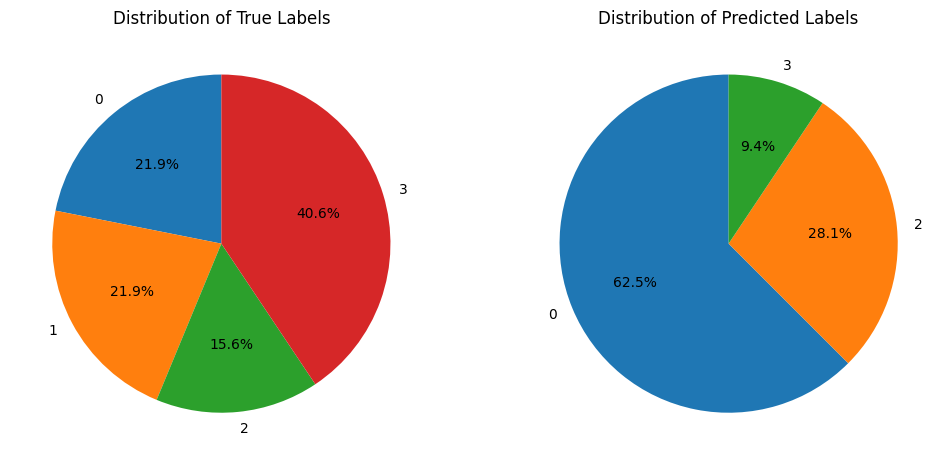

Bar chart saved as 'label_distribution_bar.png'


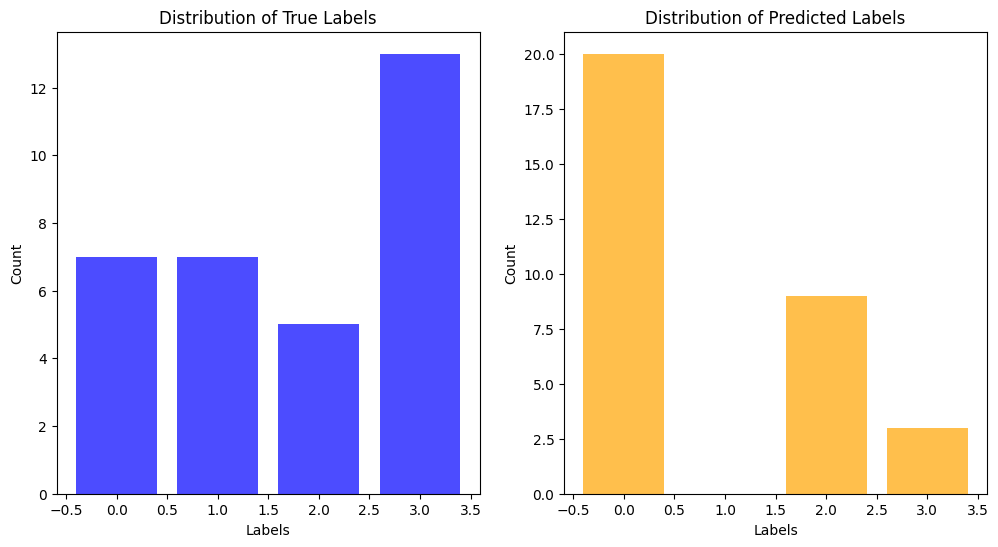

Confusion matrix saved as 'confusion_matrix.png'


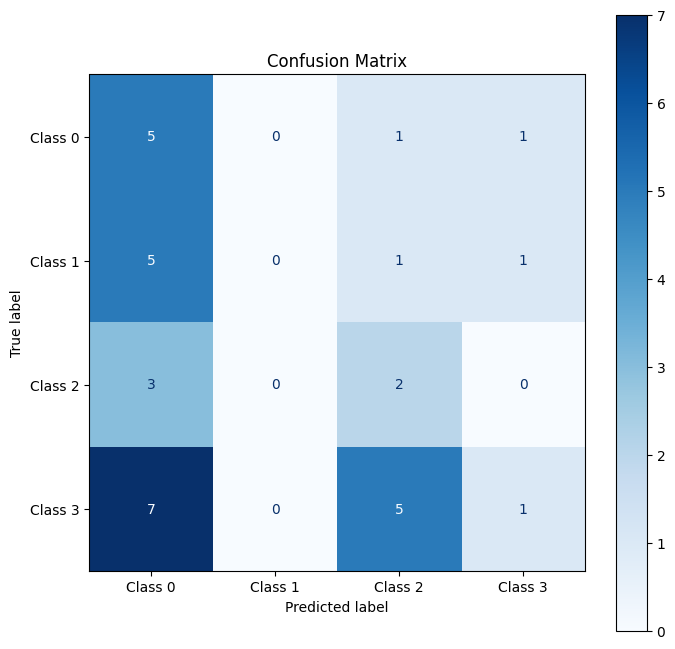

Heatmap saved as 'confusion_matrix_heatmap.png'


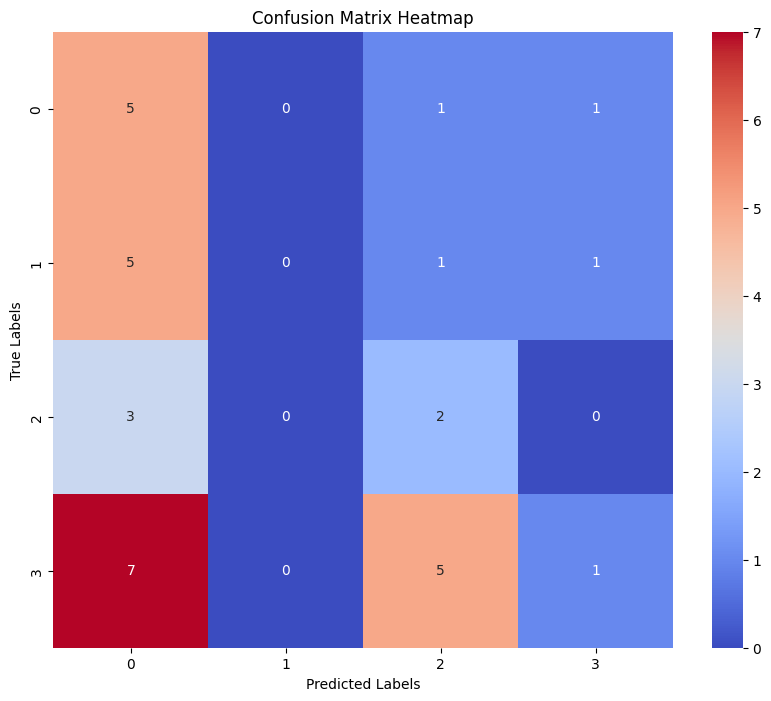

In [2]:
# visualisation
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# --- Setup Configuration ---
model_path = "/kaggle/input/cnn-model/pytorch/default/1/alzheimers_cnn_model.pth"  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# --- Load the Pre-trained Model ---
try:
    model = AlzheimerNet(num_classes=4).to(device)  
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# --- Load and Preprocess Data ---
try:
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
except Exception as e:
    print(f"Error fetching data: {e}")
    exit()

# --- Make Predictions ---
with torch.no_grad(): 
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# --- Convert Predictions and Labels ---
true_labels_np = labels.cpu().numpy()
predicted_np = predicted.cpu().numpy()

# --- Save Predictions as CSV ---
data = pd.DataFrame({
    "True Labels": true_labels_np,
    "Predicted Labels": predicted_np
})
csv_file_name = "predictions.csv"
data.to_csv(csv_file_name, index=False)
print(f"Predictions saved as '{csv_file_name}'")

# --- Label Distributions ---
true_labels, true_counts = np.unique(true_labels_np, return_counts=True)
pred_labels, pred_counts = np.unique(predicted_np, return_counts=True)

# Pie Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.pie(true_counts, labels=true_labels, autopct='%1.1f%%', startangle=90)
ax1.set_title('Distribution of True Labels')
ax2.pie(pred_counts, labels=pred_labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Predicted Labels')
plt.savefig("label_distribution_pie.png")
print("Pie chart saved as 'label_distribution_pie.png'")
plt.show()

# Bar Chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.bar(true_labels, true_counts, color='blue', alpha=0.7, label='True')
ax1.set_title('Distribution of True Labels')
ax1.set_xlabel('Labels')
ax1.set_ylabel('Count')
ax2.bar(pred_labels, pred_counts, color='orange', alpha=0.7, label='Predicted')
ax2.set_title('Distribution of Predicted Labels')
ax2.set_xlabel('Labels')
ax2.set_ylabel('Count')
plt.savefig("label_distribution_bar.png")
print("Bar chart saved as 'label_distribution_bar.png'")
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(true_labels_np, predicted_np)

# Confusion Matrix Display
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in range(len(true_labels))])
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
print("Confusion matrix saved as 'confusion_matrix.png'")
plt.show()

# Heatmap for Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", xticklabels=true_labels, yticklabels=true_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.savefig("confusion_matrix_heatmap.png")
print("Heatmap saved as 'confusion_matrix_heatmap.png'")
plt.show()
